<a href="https://colab.research.google.com/github/SLPcourse/Lecture_colab_notebooks/blob/main/Lecture_4_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a notebook for the CSC3160/MDS6002 course, lecture 4.
The corresponding lecture note is available on the course website: https://drwuz.com/CSC3160/

This notebook will cover source-filter model, fundamental frequency, and intonation. Also briefly illustrate the mel scale.

This notebook needs more work for a better shape.

In [57]:
!pip install torch>=1.2.0     #install torch
!pip install torchaudio       #install torchaudio
#sets the backend of matplotlib to the 'inline' backend
%matplotlib inline

!pip install librosa          #install librosa


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import requests
import torchaudio
import matplotlib.pyplot as plt
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa

n_fft = 512

# a function to plot spectrogram
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1, figsize=(20, 5))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


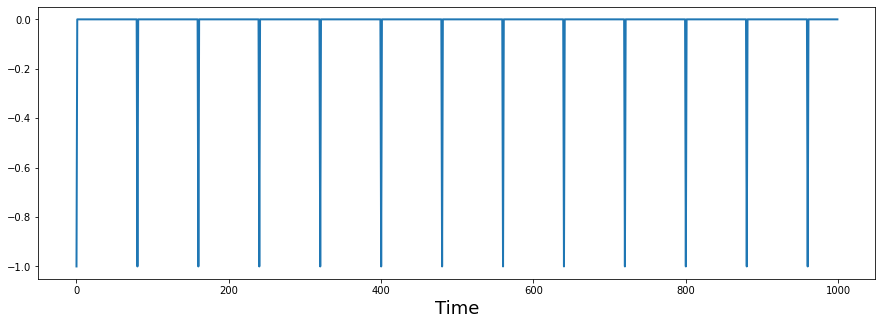

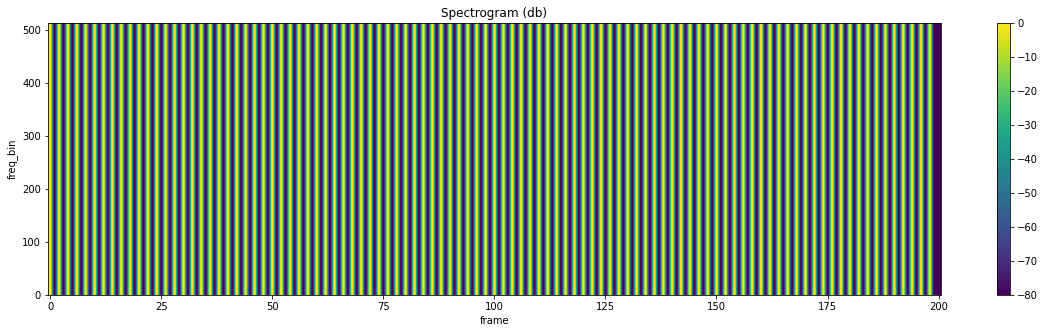

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch

F_s = 8000
e = np.zeros(int(F_s)) # 200ms at 8000 samples/second
for k in range(0,100): # 20 pitch periods
    e[k*80]=-1

plt.figure(figsize=(15, 5))
plt.plot(e[0:1000], linewidth=2)
plt.xlabel('Time', fontsize=18)

n_fft=1024
# create an object that extract spectrogram
spec_trans = T.Spectrogram(n_fft=n_fft, power=2, hop_length=40, win_length=80)

# extract spectrogram
spec = spec_trans(torch.from_numpy(e))
plot_spectrogram(spec)

ipd.display(ipd.Audio(e, rate=F_s))


# Source filter 


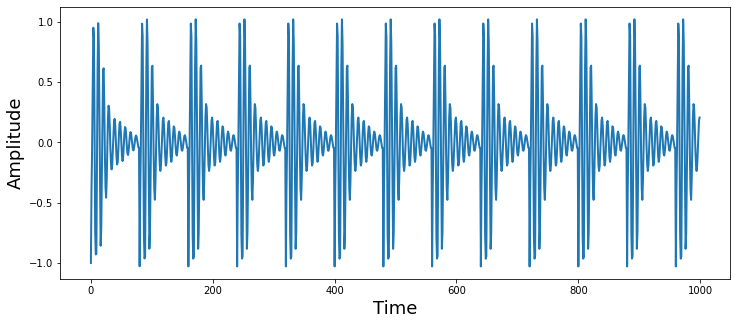

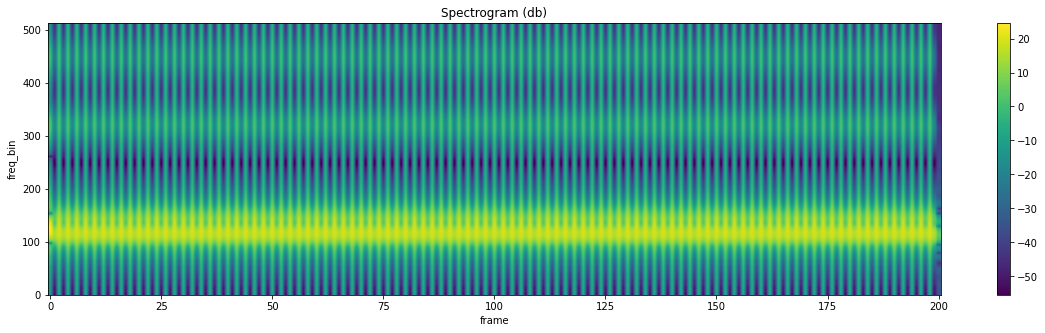

In [105]:
F = [ 900, 1100, 2500, 3500 ]
# F = [ 300, 1900, 2500, 3500 ]
# F = [ 300, 800, 2500, 3500 ]
# F = [ 500, 1800, 2500, 3500 ]
# F = [ 500, 800, 2500, 3500 ]
# F = [ 800, 1800, 2500, 3500 ]
# F = [ 500, 1500, 1900, 3500 ]

B = [ 100, 200, 300, 400 ]
F_s = 8000
omega = [ 2*np.pi*x/F_s for x in F ]
sigma = [ 2*np.pi*x/F_s for x in B ]

x = e   # start with the excitation as input to the first resonator
for m in range(0,4):
    y = np.zeros(len(x))     # create a zero-valued output
    y[0] = x[0]
    y[1] = x[1] + 2*np.exp(-sigma[m]/2)*np.cos(omega[m])*y[0]   # initialize first two samples of output
    for n in range(2,len(x)):
        y[n] = x[n] + 2*np.exp(-sigma[m]/2)*np.cos(omega[m])*y[n-1] - np.exp(-sigma[m])*y[n-2]
    x = y.copy()  # copy the output back to the input

plt.figure(figsize=(12, 5))
plt.plot(x[0:1000], linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)

# extract spectrogram
spec = spec_trans(torch.from_numpy(x))
plot_spectrogram(spec)

ipd.display(ipd.Audio(x, rate=F_s))


# Intonation

## Fundamental frequency

In [5]:
import librosa
import requests

url = "https://drwuz.com/CSC3160/materials/audio/lecture_4_expressive_speech_movie.wav"
# request the url
r = requests.get(url)

# filename, where to save the audio
filename = "lecture_4_expressive_speech_movie.wav"
with open(filename, 'wb') as f:
    f.write(r.content)

# load audio sample to memory
y, sr = librosa.load(filename)

f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=40, fmax=600)
times = librosa.times_like(f0)


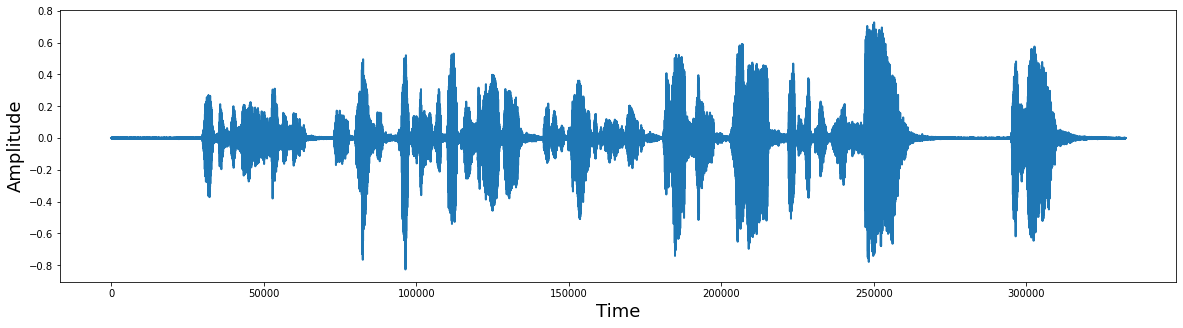

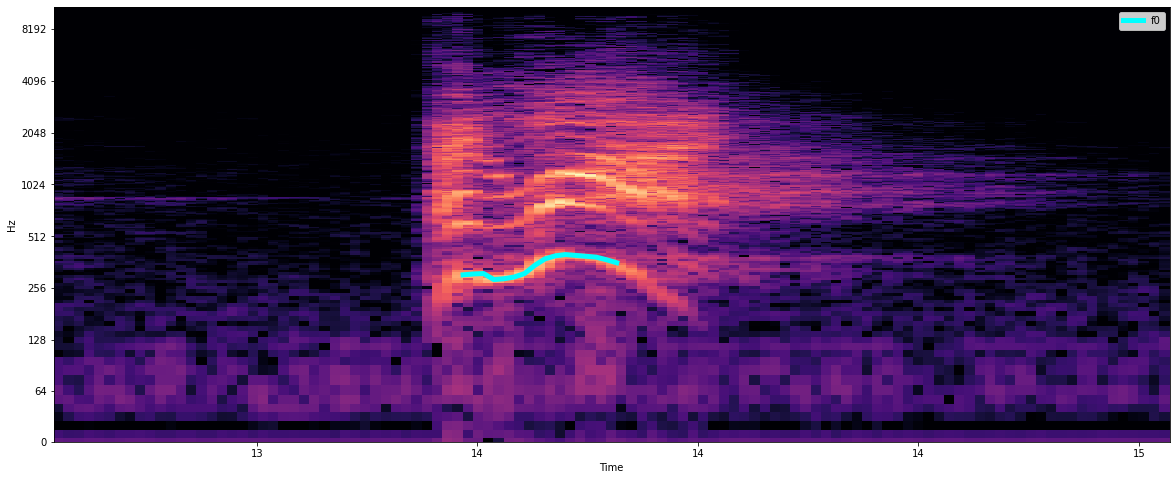

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
import IPython.display as ipd

plt.figure(figsize=(20, 5))
plt.plot(y, linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)


specgram = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots(figsize=(20, 5))
img = librosa.display.specshow(specgram[:, 40:], y_axis='log', x_axis='time', ax=ax)
ax.plot(f0[40:], label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

ipd.display(ipd.Audio(y, rate=sr))

times = librosa.times_like(f0)
specgram = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots(figsize=(20, 8))
img = librosa.display.specshow(specgram[:, 540:], x_coords=times[540:], y_axis='log', x_axis='time', ax=ax)
ax.plot(times[540:], f0[540:], label='f0', color='cyan', linewidth=5)
ax.legend(loc='upper right')


# Different spoken version of 'Mom"

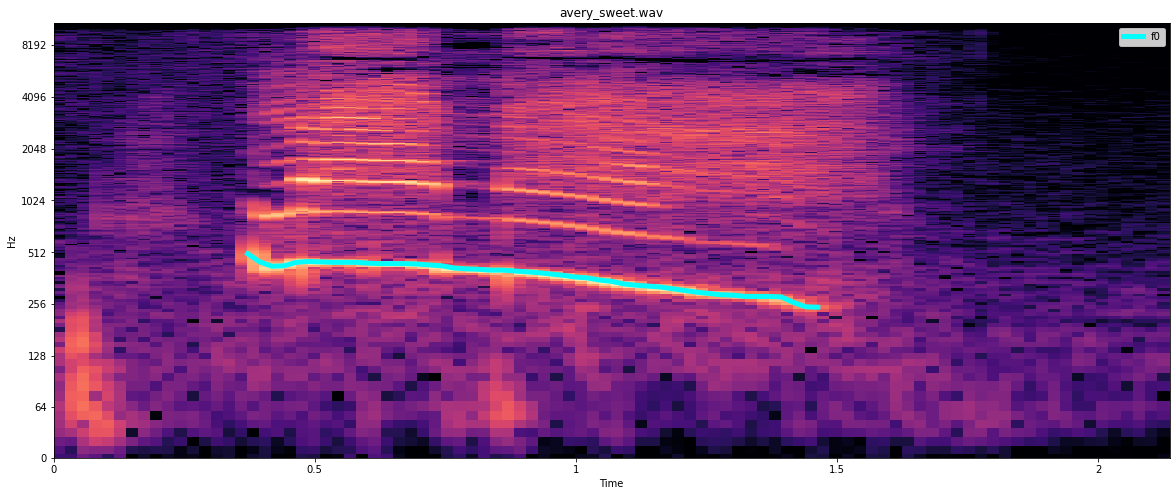

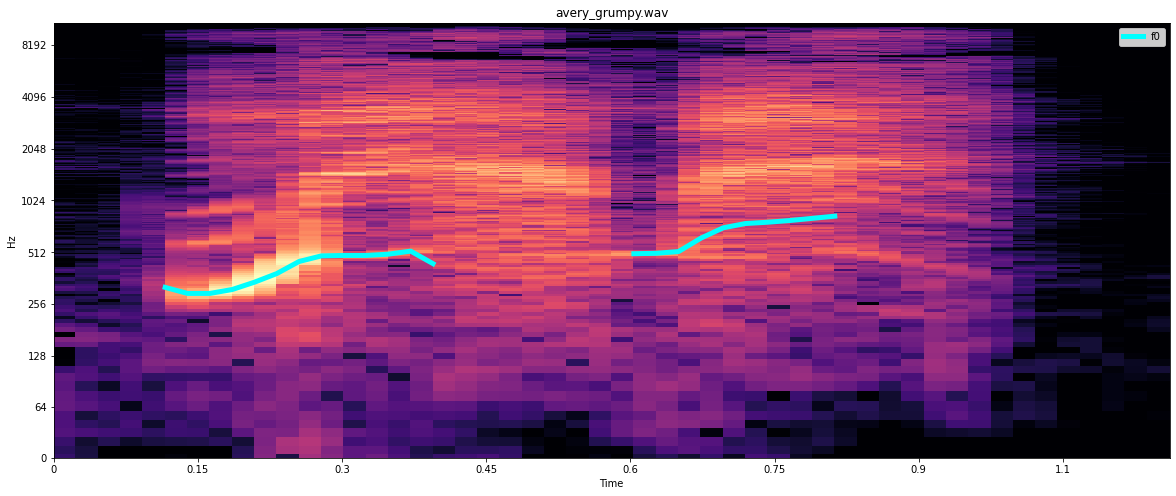

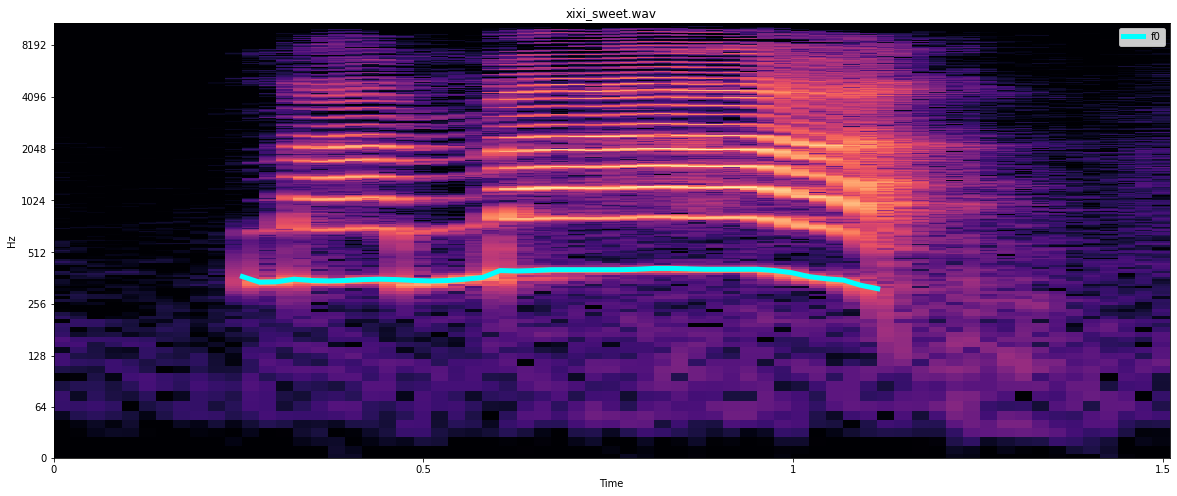

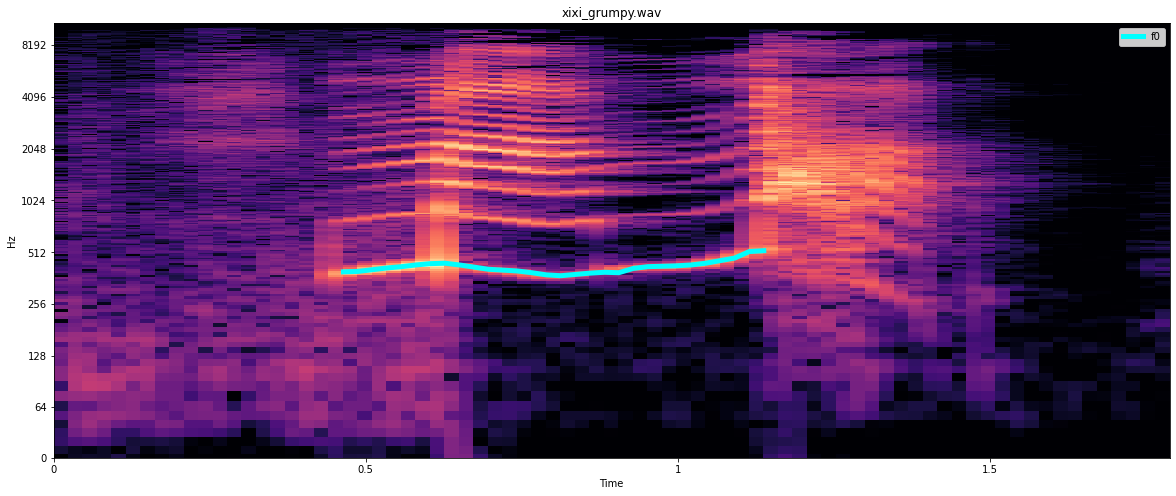

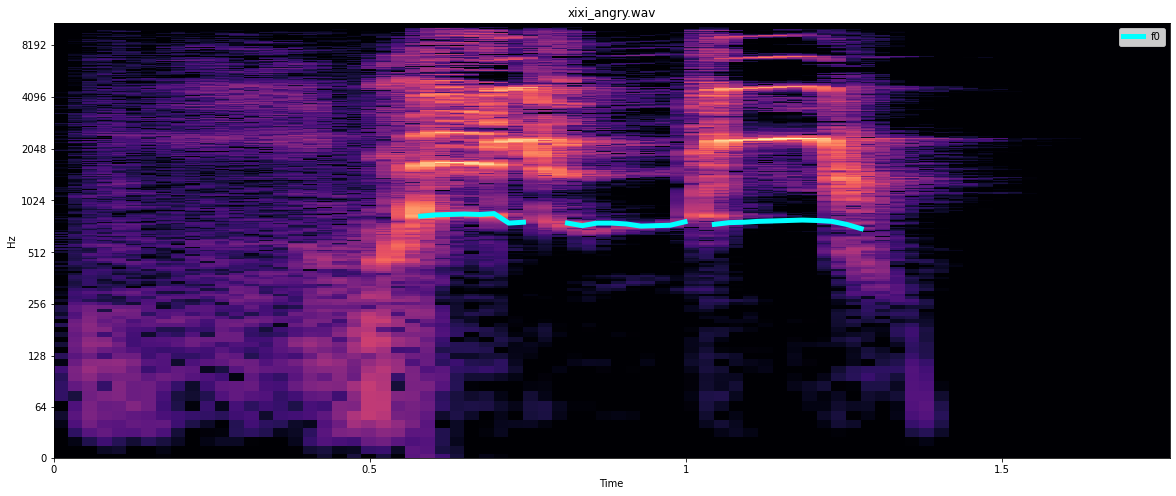

In [4]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import requests
import IPython.display as ipd
import librosa.display

for filename in ['avery_sweet.wav', 'avery_grumpy.wav', 'xixi_sweet.wav', 'xixi_grumpy.wav', 'xixi_angry.wav']:
    url = "https://drwuz.com/CSC3160/materials/audio/" + filename
    # request the url
    r = requests.get(url)

    # filename, where to save the audio
    with open(filename, 'wb') as f:
        f.write(r.content)

    # load audio sample to memory
    y, sr = librosa.load(filename)

    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=40, fmax=1000)
    times = librosa.times_like(f0)

    specgram = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    fig, ax = plt.subplots(figsize=(20, 8))
    img = librosa.display.specshow(specgram, x_coords=times, y_axis='log', x_axis='time', ax=ax)
    ax.plot(times, f0, label='f0', color='cyan', linewidth=5)
    ax.legend(loc='upper right')
    ax.set_title(filename)

    ipd.display(ipd.Audio(y, rate=sr))


# Mel Scale

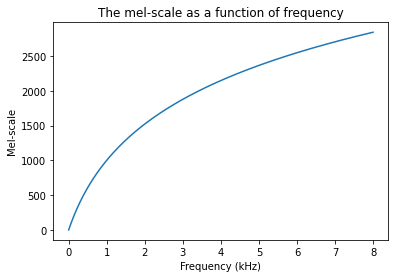

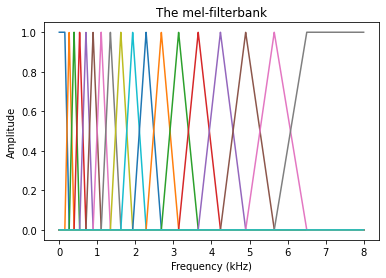

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# frequency to mel-scale
def freq2mel(f): 
    return 2595*np.log10(1 + (f/700))

# mel-scale to frequency
def mel2freq(m): 
    return 700*(10**(m/2595) - 1)

f = np.linspace(0,8000,1000)
plt.plot(f/1000,freq2mel(f))
plt.xlabel('Frequency (kHz)')
plt.ylabel('Mel-scale')
plt.title('The mel-scale as a function of frequency')
plt.show()

spectrum_length = 8000

melbands = 20
maxmel = freq2mel(8000)
mel_idx = np.array(np.arange(.5,melbands,1)/melbands)*maxmel
freq_idx = mel2freq(mel_idx)

melfilterbank = np.zeros((spectrum_length,melbands))
freqvec = np.arange(0,spectrum_length,1)*8000/spectrum_length
for k in range(melbands-2):    
    if k>0:
        upslope = (freqvec-freq_idx[k])/(freq_idx[k+1]-freq_idx[k])
    else:
        upslope = 1 + 0*freqvec
    if k<melbands-3:
        downslope = 1 - (freqvec-freq_idx[k+1])/(freq_idx[k+2]-freq_idx[k+1])
    else:
        downslope = 1 + 0*freqvec
    triangle = np.max([0*freqvec,np.min([upslope,downslope],axis=0)],axis=0)
    melfilterbank[:,k] = triangle
    
melreconstruct = np.matmul(np.diag(np.sum(melfilterbank**2+1e-12,axis=0)**-1),np.transpose(melfilterbank))
    
plt.plot(freqvec/1000,melfilterbank)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')
plt.title('The mel-filterbank')
plt.show()
